# Appendix C.3 Rational subgroups of Shewhart's initial resistance measurements

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd

from process_improvement import xmr_charts as xmr
from process_improvement import comparison_charts as cc

%matplotlib inline

## Step 1. Get the data

In [2]:
# Dataset url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/shewharts-resistance-measurements.csv'

# Get data
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
resistance_df = get_data()

# Make 'Year' column dtype string
resistance_df['Value'] = resistance_df['Value'].astype('string')

# Drop 'Units' column
resistance_df = resistance_df.drop('Units', axis=1)

# Create initial_df
initial_df = resistance_df[resistance_df['Stage'] == 'Initial']
# Show initial_df
initial_df

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290
...,...,...,...
199,Initial,200,4625
200,Initial,201,5150
201,Initial,202,5250
202,Initial,203,5000


## Form rational subgroups of n = 4

In [3]:
# Calculate the subgroup means
initial_subgrouped = (initial_df['Resistance']
                      .groupby(initial_df.index // 4)
                      .mean()
                      .to_frame()
                      .rename(columns={'Resistance':'Subgroup Mean'})
                     )
initial_subgrouped.head()

,Subgroup Mean
0,4430.00
1,4372.50
2,3827.50
3,3912.00
4,5071.25


In [4]:
# Calculate the subgroup ranges
initial_subgrouped['Subgroup Range'] = (initial_df['Resistance']
                                    .groupby(initial_df.index // 4)
                                    .agg(lambda x: x.max() - x.min()))
# Add a 'Subgroups' column to subgroup dataframes
initial_subgrouped['Subgroup'] = (pd.Series(np.arange(1, len(initial_subgrouped)+1))
                                   .astype('string'))
initial_subgrouped.head()

,Subgroup Mean,Subgroup Range,Subgroup
0,4430.00,1070,1
1,4372.50,200,2
2,3827.50,335,3
3,3912.00,1900,4
4,5071.25,815,5


## Step 2. Calculate the grand average

In [5]:
# Specify round_value
round_value = 1

# Calculate the grand average (average of the subgroup averages)
grand_ave = round(initial_subgrouped['Subgroup Mean'].mean(),round_value)

# Show grand average
print('Grand Average:', grand_ave)

Grand Average: 4498.2


## Step 3. Calculate the average range

In [6]:
# Calculate the average range (average of the subgroup ranges)
ave_range = round(initial_subgrouped['Subgroup Range'].mean(),round_value)

print('Average Range:', ave_range)

Average Range: 658.6


## Step 4. Calculate the process limits

In [7]:
# Calculate the process limits for the average and range chart
# Specify A2 for subgroup size n=4
A2 = 0.729
# Specify D3 and D4 for subgroups of size n=4
D3 = -0.282
D4 = 2.282

# Calculate the Average Chart limits
UAL = round(grand_ave + (A2*ave_range),round_value)
LAL = round(grand_ave - (A2*ave_range),round_value)

# Calculate the Range Chart limits
range_URL = round(D4*ave_range,round_value)
range_LRL = max(0, round(D3*ave_range))

# Print results
print("Upper Average Limit:", UAL)
print("Lower Average Limit:", LAL)
print("Upper Range Limit:", range_URL)
print("Lower Range Limit:", range_LRL)

Upper Average Limit: 4978.3
Lower Average Limit: 4018.1
Upper Range Limit: 1502.9
Lower Range Limit: 0


## Step 5. Put it all together

In [8]:
# Build the average and range chart elements
data = initial_subgrouped['Subgroup Mean']
labels = initial_subgrouped['Subgroup']
moving_ranges = initial_subgrouped['Subgroup Range']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UAL, data)
lower_lim = np.ma.masked_where(data > LAL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= range_URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > range_LRL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
average_chart_lines = [(grand_ave, '-', 'black'), (UAL, '--', 'red'), (LAL, '--', 'red')]
range_chart_lines = [(ave_range, '-', 'black'), (range_URL, '--', 'red'), (range_LRL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
average_chart_labels = [(UAL,UAL),(LAL,LAL),(grand_ave,grand_ave)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
range_chart_labels = [(range_URL,range_URL),(ave_range,ave_range)]

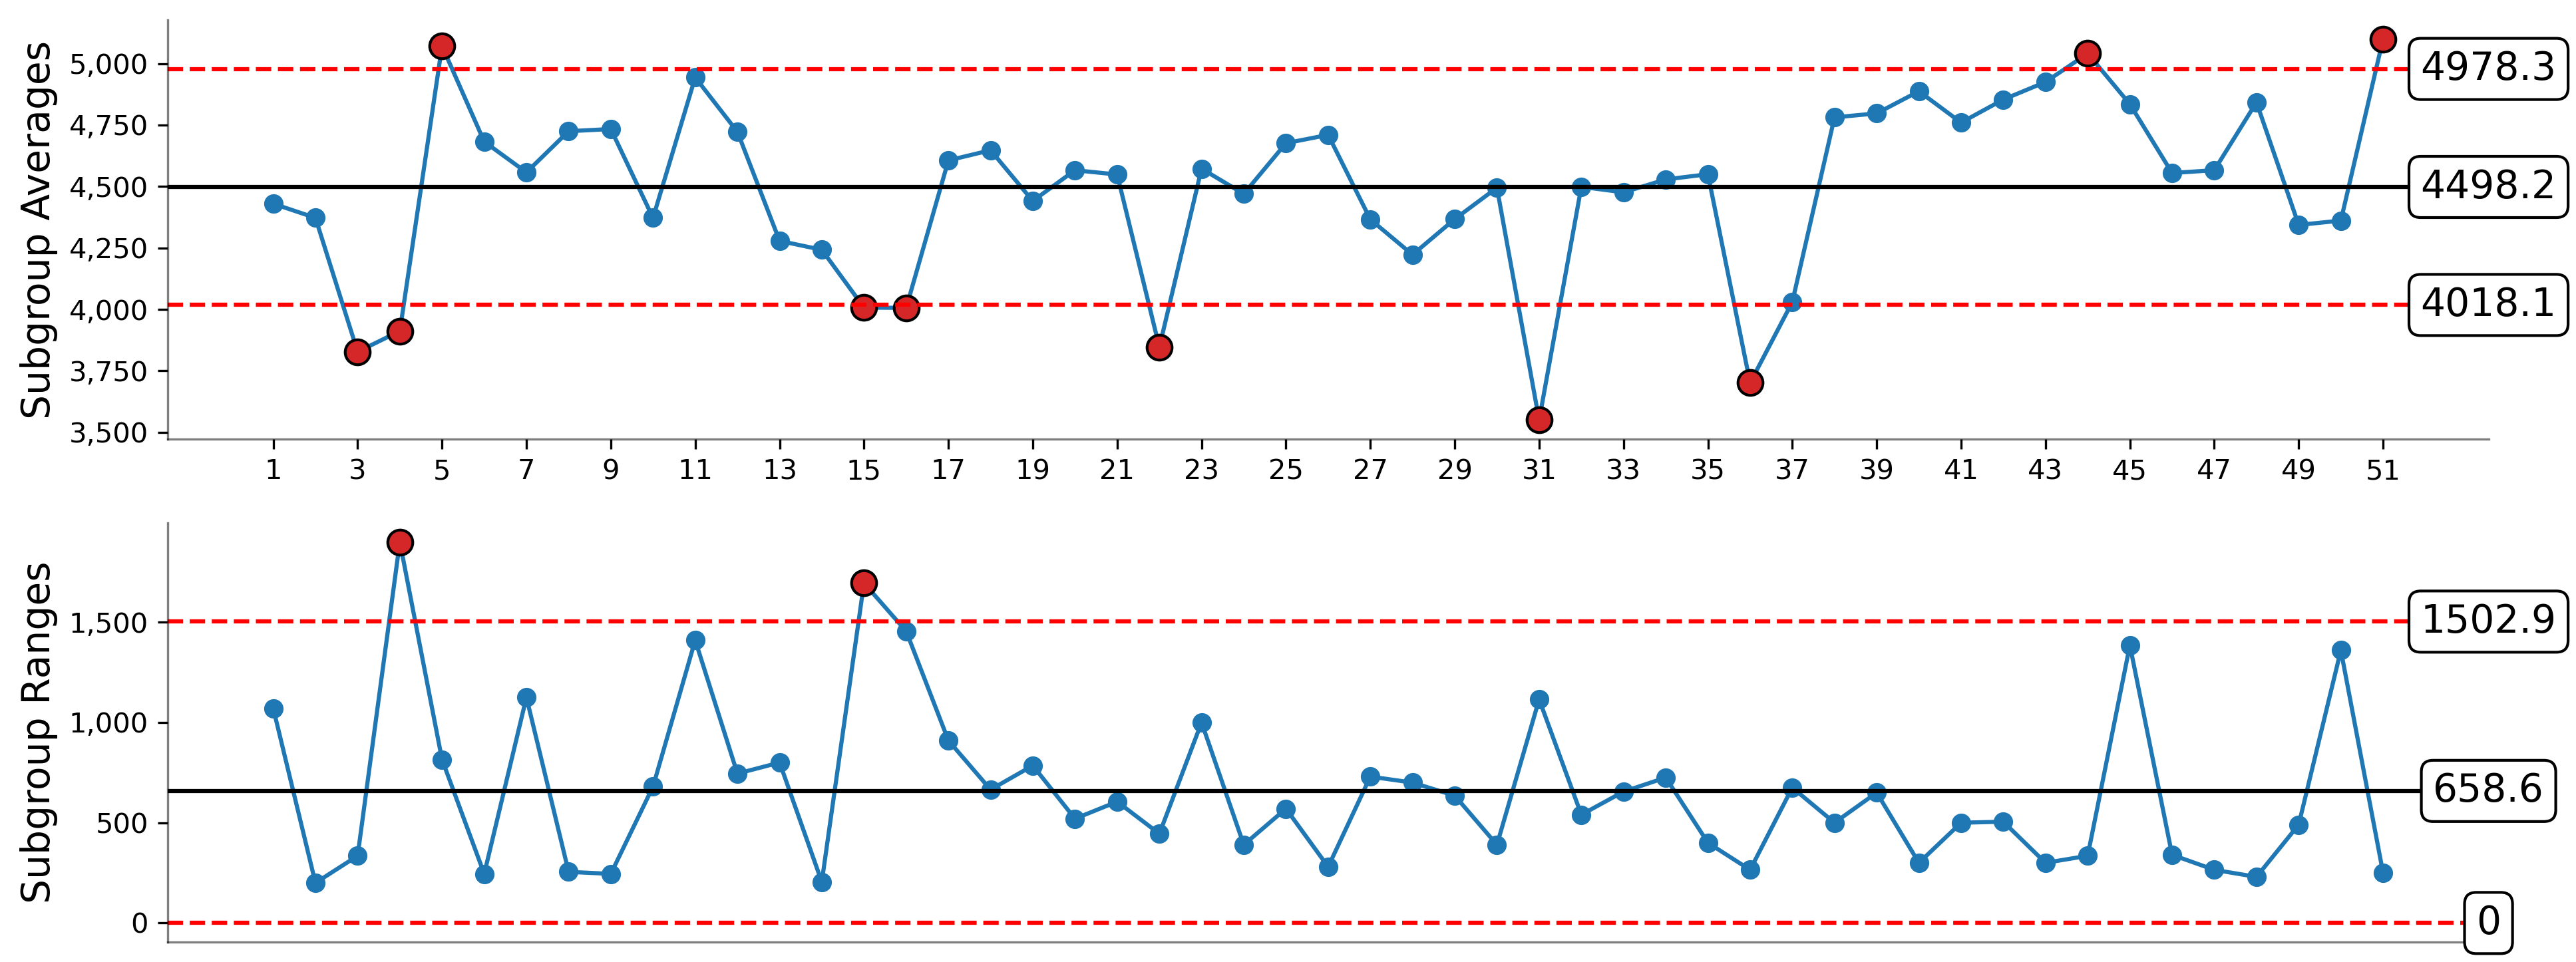

In [9]:
# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

for val in [UAL, LAL, grand_ave]:
    axs[0].text(axs[0].get_xlim()[1], val, val, color='black', ha='center', va='center', 
                fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linetype, color in average_chart_lines:
    axs[0].axhline(value, ls=linetype, c=color)
    
# Plot subgroup ranges on range chart
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[1].plot(labels, url_less, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

for val in [range_URL, range_LRL, ave_range]:
    axs[1].text(axs[1].get_xlim()[1], val, val, color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linetype, color in range_chart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# # Set the x-tick labels with increased intervals
tick_interval = 2  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Subgroup Averages", fontsize=14)

axs[1].set_xlabel("",fontsize=12)
axs[1].set_ylabel("Subgroup Ranges", fontsize=14)

axs[1].set_xticks([])

# Despine
sns.despine()
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Set titles
# axs[0].set_title("Average and Range Chart of Resistance Measurements", 
#                  fontsize=16)

for val in range(0,2):
    axs[val].yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: f'{int(y):,}' if y >= 1000 else f'{int(y)}'
    ))

# Show plot
plt.show()